## Q5 Multiple Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stan
import pandas as pd
import arviz as az
import seaborn as sns
import nest_asyncio
nest_asyncio.apply()

Define the multple regression model...

In [2]:
program_code = """
data {
    int<lower=1> N; // training count
    int<lower=1> K; // weight count
    int<lower=1> T; // test count
    vector[N] charges; // training output
    matrix[N,K] params; // training input
    matrix[K,K] covariance; // covaraiance for multi_norm
    matrix[T,K] test_params; // testing input
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ inv_gamma(3.0, 1.0);
    alpha ~ normal(0, 10.0);
    beta ~ multi_normal([0.0, 0.0, 0.0], covariance);
    
    // Likelihood
    for (n in 1:N) {
        charges[n] ~ normal(alpha + (params[n] * beta), sigma);
    }
}

generated quantities {
    vector[T] pred_signal;
    for (n in 1:T) {
        pred_signal[n] = normal_rng(alpha + (test_params[n] * beta), sigma);
    }
}

"""

Load data and normalize

In [35]:
samples = pd.read_csv("insurance.csv", delimiter=',')
N = len(samples)
K = 3

parameters = samples[["age", "bmi", "children"]]
parameters = (parameters - parameters.mean()) / parameters.std()
labels = samples["charges"]
labels = (labels - labels.mean()) / labels.std()

cutoff = int(N*0.70)
training_params, test_params = parameters.iloc[:cutoff], parameters.iloc[cutoff:]
training_labels, test_labels = labels.iloc[:cutoff], labels.iloc[cutoff:]

data = {
    'N' : cutoff,
    'K' : K,
    'T' : len(labels) - cutoff,
    'charges' : training_labels.to_list(),
    'params' : training_params.to_numpy(),
    'covariance' : np.eye(K) * 3.0,
    'test_params' : test_params.to_numpy()
}

Compile model

In [36]:
model = stan.build(program_code=program_code, data=data)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Sample fitted distribution

In [37]:
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=1000)
results = fit.to_frame()

Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  14% (1100/8000)
Sampling:  21% (1700/8000)
Sampling:  29% (2300/8000)
Sampling:  50% (4000/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000159 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.59 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_wg2ad9k9/model_vm3fepqj.stan', line 26, column 8 to column 63)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

Diagnose convergence  
beta0 -> age  
beta1 -> bmi  
beta2 -> num children  
  
From the below tables, it appears age (beta0) has the greatest influence over the insurance charge, and is thus the best predictor

In [38]:
az.summary(fit, var_names=['alpha', 'sigma', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.030,0.031,-0.089,0.028,0.0,0.0,4819.0,3211.0,1.0
sigma,0.928,0.021,0.889,0.968,0.0,0.0,4548.0,3407.0,1.0
beta[0],0.300,0.029,0.248,0.357,0.0,0.0,5553.0,3335.0,1.0
beta[1],0.158,0.031,0.096,0.212,0.0,0.0,5157.0,3261.0,1.0
beta[2],0.034,0.031,-0.025,0.090,0.0,0.0,5480.0,3161.0,1.0


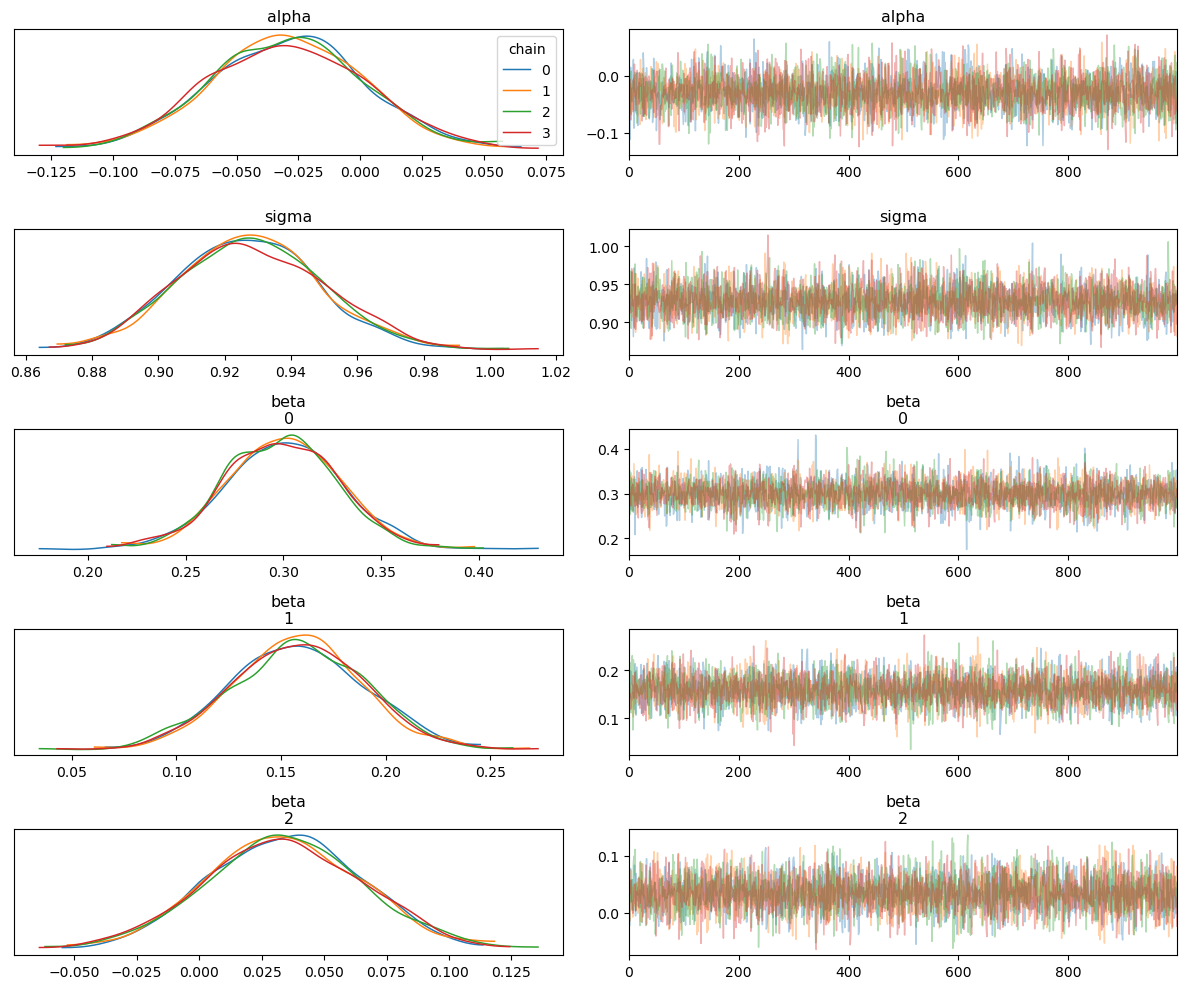

In [39]:
f = az.plot_trace(fit, compact=False, legend=True, var_names=['alpha', 'sigma', 'beta'])
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

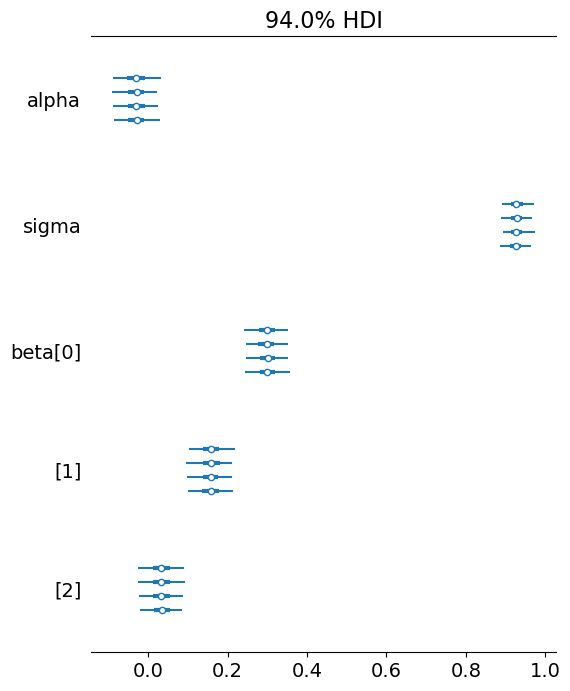

In [40]:
az.plot_forest(fit, var_names=['alpha', 'sigma', 'beta'])

/home/chase/miniconda3/envs/cog/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'RMSE')

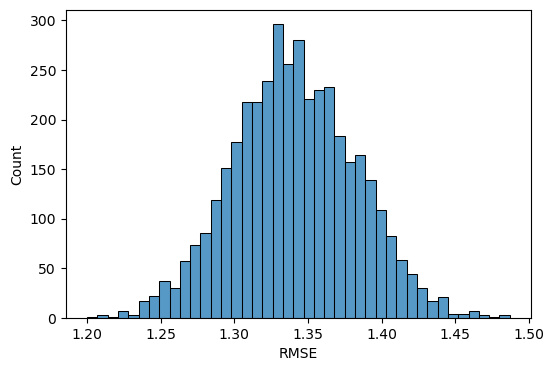

In [41]:
f, ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.sqrt(np.mean((results.iloc[:, 12:] - test_labels.values) ** 2, axis=1)), ax=ax)
ax.set_xlabel("RMSE")